In [1]:
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [2]:
import pathlib
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline.torch

import metatensor.torch as mts

from metatensor.torch import Labels, TensorBlock, TensorMap
from metatensor.learn import IndexedDataset, DataLoader
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts

from mlelec.data.dataset import QMDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis, lowdin_orthogonalize
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import compute_features
from mlelec.utils.target_utils import get_targets
# from mlelec.models.linear import LinearModelPeriodic
from mlelec.models.linear_symmetry import LinearModelPeriodic
from mlelec.metrics import L2_loss, L2_loss_meanzero

/Users/jigyasa/miniconda3/lib/python3.12/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
device = 'cpu'

orbitals = {
    'sto-3g': {
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
              }, 
    
}

# Dataset

In [4]:
# workdir = './

workdir = f'{pathlib.Path().resolve()}/examples/data/periodic/c2-cp2k-benchmarks'
START = 0 
STOP = 2
SKIP = 1
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root

frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0_target = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]
rfock_diff_target = []
for K, K0 in zip(rfock, rfock0_target):
    rfock_diff_target.append({})
    for T in K:
        rfock_diff_target[-1][T] = K[T] -K0[T]
        
dataset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

## Testset

In [5]:
# workdir = './'
workdir = './examples/data/periodic/c2-cp2k-benchmarks'
START = 3
STOP = 8
SKIP = 1
ORBS = 'sto-3g'
root = f'{workdir}'#/examples/data/periodic/c2/cp2k/sto-3g'
data_dir = root
frames = read(f'{data_dir}/C2_174.extxyz', slice(START, SKIP*STOP, SKIP))
rfock = [np.load(f"{data_dir}/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rfock0_test = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
rover = [np.load(f"{data_dir}/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, SKIP*STOP, SKIP)]
# rover0 = [np.load(f"{data_dir}/baseline/C2_174_881_{i}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [8,8,1]

for f in frames:
    f.pbc = [True,True,False]
    f.wrap(center = (0,0,0), eps = 1e-60)
    f.pbc = True

# for K, K0 in zip(rfock, rfock0):
#     for T in K:
#         K[T] = K[T] - K0[T]
rfock_diff_test= []
for K, K0 in zip(rfock, rfock0_test):
    rfock_diff_test.append({})
    for T in K:
        rfock_diff_test[-1][T] = K[T] -K0[T]
        

testset = QMDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

FileNotFoundError: [Errno 2] No such file or directory: './examples/data/periodic/c2-cp2k-benchmarks/baseline/C2_174_881_3/realfock_3.npy'

In [ ]:
# for ifr in range(len(rover)):
#     for T in rover[ifr]:
#         print(ifr, T, np.linalg.norm(rover[ifr][T]- rover0[ifr][T]))

## Compute target

In [25]:
cutoff = 8
SORT_ORBS = True
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')
target_blocks_base, target_coupled_blocks_base = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff_target)
_, target_coupled_blocks_fock0 = get_targets(dataset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0_target)


In [8]:
_, test_coupled_blocks = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS)
_, overlap_coupled_blocks_test = get_targets(dataset, cutoff = cutoff, device = device, target = 'overlap')
test_blocks_base, test_coupled_blocks_base = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock_diff_test)
_, test_coupled_blocks_fock0 = get_targets(testset, cutoff = cutoff, device = device, all_pairs = False, sort_orbs=SORT_ORBS, matrix=rfock0_test )


In [8]:
target_kspace = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks, dataset))
target_kspace_base = dataset.bloch_sum(blocks_to_matrix(target_coupled_blocks_base, dataset))
overlap_kspace = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks, dataset))

# test_kspace = testset.bloch_sum(blocks_to_matrix(test_coupled_blocks, testset))
# test_kspace_base = testset.bloch_sum(blocks_to_matrix(test_coupled_blocks_base, testset))
# overlap_kspace_test = dataset.bloch_sum(blocks_to_matrix(overlap_coupled_blocks_test, testset))

# Features 

In [7]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3
spline_basis = False

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

hfeat = compute_features(dataset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features
cpu single center features
cpu single center features


In [47]:
hfeat[1].values.shape, hfeat[4].values.shape

(torch.Size([4, 3, 288]), torch.Size([4, 3, 144]))

In [11]:
hfeat_test = compute_features(testset, hypers_atom, hypers_pair=hypers_pair, lcut = LCUT, all_pairs=False)

cpu pair features


cpu single center features
cpu single center features


# Model

In [9]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
from mlelec.models.linear import LinearModelPeriodic
model = LinearModelPeriodic(twocfeat = hfeat, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 32, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

model = model.double()

## RIDGE models 

In [13]:
def train_ridge(model, target_blocks, set_bias=False, alphas = None, kernel_ridge = False, alpha = None):
    block_losses = {}
    loss = 0
    pred, ridges = model.fit_ridge_analytical(return_matrix = False, set_bias = set_bias, kernel_ridge = kernel_ridge, alphas = alphas, alpha = alpha)

    for (key, block) in pred.items():
        block_loss=torch.norm(block.values - target_blocks[key].values)**2
        loss += block_loss
        
        block_losses[tuple(key.values)] = block_loss

    # print(np.sum(list(block_losses.values())))
    return loss, pred, ridges, block_losses#, kernels 

### A - direct H(T)

In [14]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(3.1771e-06)


In [15]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)
L2_loss(test_coupled_blocks, pred_test_ridge)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:782: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


tensor(0.0033)

### B. - baselined H(T)

In [16]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat, 
                                  target_blocks = target_coupled_blocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         # alphas = np.logspace(-10, -2, 100),
                                                                         alphas = np.logspace(-10, 1, 100),
                                                                         # alpha = 1e-4
                                                                        )
print(loss_ridge_bias)
pred_ht = mts.add(pred_ridge_bias, target_coupled_blocks_fock0)
L2_loss(pred_ht, target_coupled_blocks)

tensor(5.2701e-09)


tensor(5.2701e-09)

In [17]:
pred_test_ridge = model_ridge.predict_ridge_analytical(ridges_bias, hfeat_test)
# pred_ht = mts.add(pred_test_ridge, test_coupled_blocks_fock0)
# L2_loss(test_coupled_blocks, pred_ht)

/media/nigam/b5749eb7-d3f1-4495-adeb-2c318fb7d0de/MAC/mlelec/src/mlelec/models/linear.py:782: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train target_blocks, otherwise provide test target_blocks')


### D. -  H(k)

In [48]:
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums, TMap_bloch_sums_feat
phase, indices ,_= precompute_phase(hfeat, dataset)
hfeat_kspace = TMap_bloch_sums_feat(hfeat, phase, indices, _, return_tensormap=True)

In [49]:
# (target_coupled_blocks[4].values[0]*np.sqrt(2)+torch.sum(target_coupled_blocks[11].values[:38], axis=0))
# ((hfeat[0].values[0]*np.sqrt(2)+torch.sum(hfeat[7].values[:38], axis=0)) - hfeat_kspace[0].values[0]).norm()

In [50]:
phase, indices ,_= precompute_phase(target_coupled_blocks, dataset)
target_coupled_blocks_k = TMap_bloch_sums(target_coupled_blocks, phase, indices, _, return_tensormap=True)

In [51]:
kblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff),skip_symmetry = False, device = device, translations = False)

In [88]:
from mlelec.utils.metatensor_utils import sort_block_hack, sort_hack
for (k1, b1)in target_coupled_blocks_k.items():
    # b1 = sort_block_hack(b1)
    b2 = kblocks.block(k1)
    b2 = sort_block_hack(b2)
    # b2 = _match_feature_and_target_samples(b1, b2, return_idx=True)
    _,m1,m2 = b1.samples.intersection_and_mapping(b2.samples)
    b2val = b2.values[m2]
    assert torch.all(b1.samples.values[m1] == b2.samples.values[m2]), (b1.samples.values[m1], b2.samples.values[m2])
    # print(k1.values, b1.values.shape,b2.values.shape)
    print(k1.values, (b1.values-b2val).norm())

tensor([-1,  6,  1,  0,  6,  2,  0,  0], dtype=torch.int32) tensor(2.3452e-15)
tensor([-1,  6,  1,  0,  6,  2,  1,  1], dtype=torch.int32) tensor(8.6941e-15)
tensor([-1,  6,  2,  0,  6,  2,  1,  1], dtype=torch.int32) tensor(3.5022e-09)
tensor([-1,  6,  2,  1,  6,  2,  1,  1], dtype=torch.int32) tensor(7.3161e-14)
tensor([1, 6, 1, 0, 6, 1, 0, 0], dtype=torch.int32) tensor(8.5487e-14)
tensor([1, 6, 1, 0, 6, 2, 0, 0], dtype=torch.int32) tensor(2.3656e-14)
tensor([1, 6, 1, 0, 6, 2, 1, 1], dtype=torch.int32) tensor(3.7698e-15)
tensor([1, 6, 2, 0, 6, 2, 0, 0], dtype=torch.int32) tensor(1.6346e-09)
tensor([1, 6, 2, 0, 6, 2, 1, 1], dtype=torch.int32) tensor(2.5883e-11)
tensor([1, 6, 2, 1, 6, 2, 1, 0], dtype=torch.int32) tensor(1.3456e-08)
tensor([1, 6, 2, 1, 6, 2, 1, 2], dtype=torch.int32) tensor(2.0125e-08)


In [89]:
kblocks = sort_hack(kblocks)

In [54]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


(1e-10, 0.0005232541480597252)

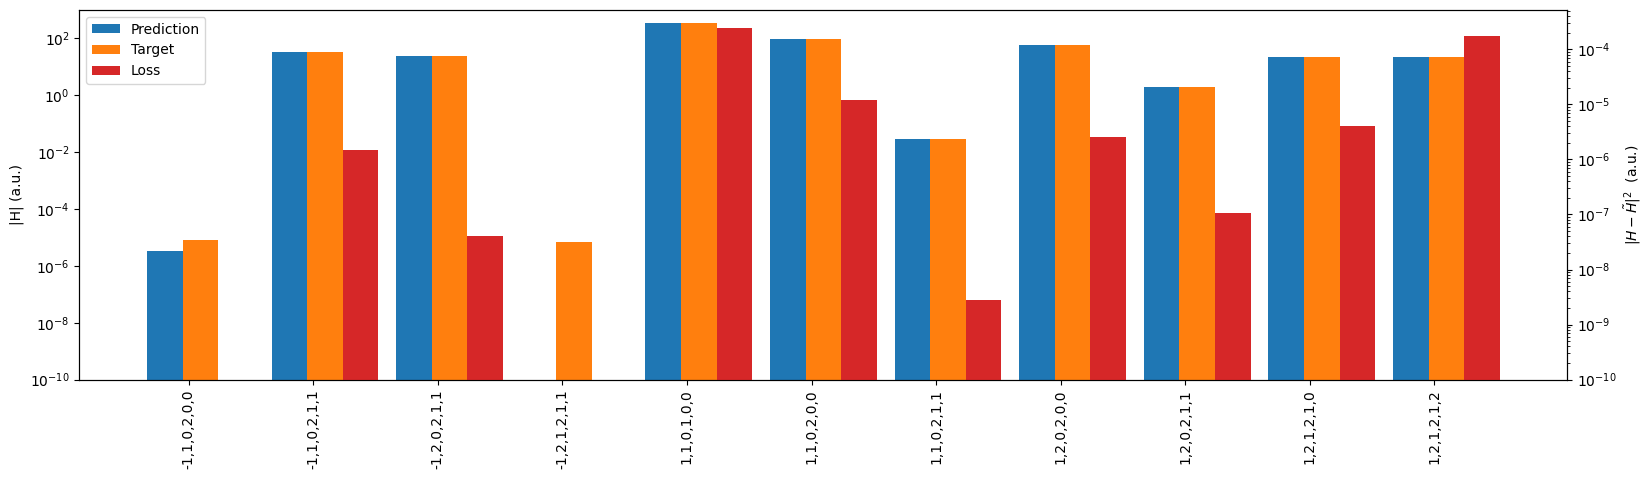

In [22]:
fig, ax, ax2 = plot_block_errors(target_coupled_blocks_k, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

In [92]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = kblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         kblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.0004)


### E. - baselined H(k)

In [22]:
phase, indices ,_= precompute_phase(target_coupled_blocks_base, dataset)
target_coupled_blocks_base_k = TMap_bloch_sums(target_coupled_blocks_base, phase, indices, _, return_tensormap=True)

In [23]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = target_coupled_blocks_base_k,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         target_coupled_blocks_base_k,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7, 2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(7.4700e-07)


### G. - orthogonalize H(k) 

In [105]:
ortho_target_kspace =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace[ifr], overlap_kspace[ifr])])
    ortho_target_kspace.append(ot)

In [106]:
e_ortho=[]
for ifr in range(len(ortho_target_kspace)):
   eifr=[]
   for k in range(len(ortho_target_kspace[ifr])):
      eifr.append(torch.linalg.eigvalsh(ortho_target_kspace[ifr][k]))
   e_ortho.append(torch.stack(eifr))

In [107]:
import scipy
e_nonorth=[]
for ifr in range(len(target_kspace)):
   eifr=[]
   for k in range(len(target_kspace[ifr])):
      eifr.append(torch.tensor(scipy.linalg.eigvalsh(target_kspace[ifr][k], overlap_kspace[ifr][k])))
   e_nonorth.append(torch.stack(eifr))

In [108]:
for ifr in range(len(dataset)):
    print(ifr, torch.norm(e_ortho[ifr]-e_nonorth[ifr]))

0 tensor(1.3181e-13)
1 tensor(1.3615e-13)
2 tensor(1.4274e-13)
3 tensor(1.1559e-13)
4 tensor(1.1993e-13)


In [62]:
# plt.plot(torch.cat(e_ortho).numpy(), torch.cat(e_nonorth).numpy(), 'o')

In [109]:
oblocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace),skip_symmetry = False, device = device, translations = False)
oblocks = sort_hack(oblocks)

In [114]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-20,4, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(10058.2337)


(1e-10, 5432.72529376023)

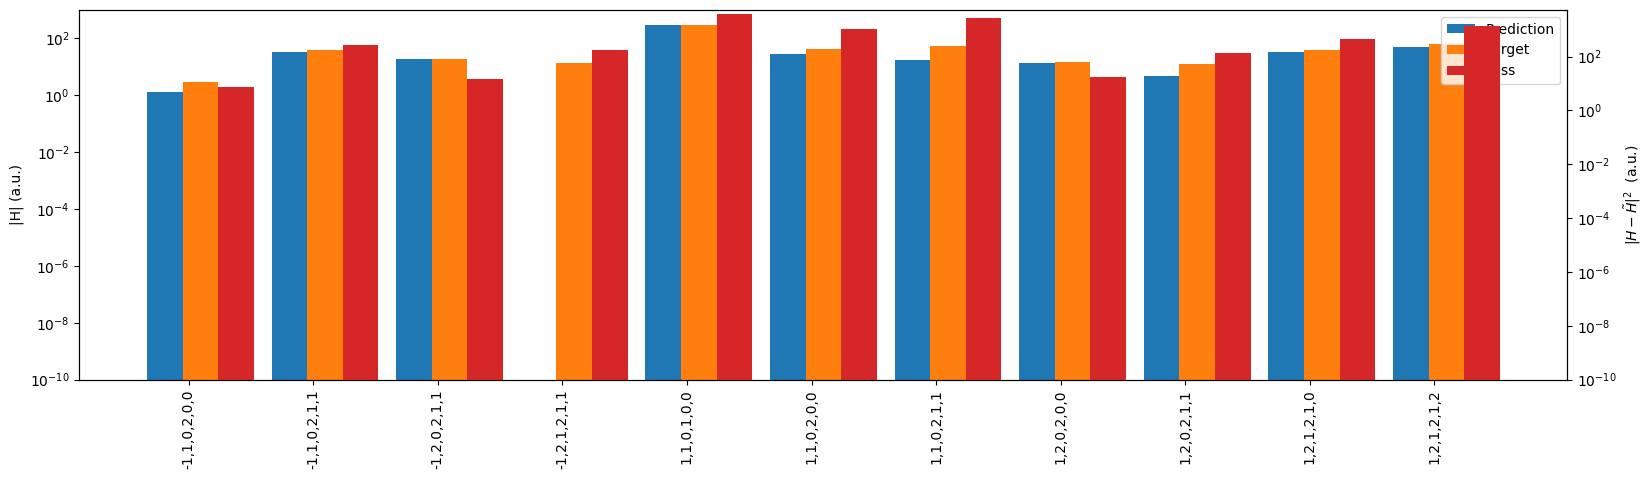

In [115]:
fig, ax, ax2 = plot_block_errors(oblocks, pred_ridge_bias, plot_loss=True)
ax.set_ylim(1e-10,)
ax2.set_ylim(1e-10,)

### H. - orthogonalize baseline

In [100]:
ortho_target_kspace_base =[]# torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(ttarget_kspace, overlap_kspace)])
for ifr in range(len(target_kspace)):
    ot = torch.stack([lowdin_orthogonalize(h, s) for h, s in zip(target_kspace_base[ifr], overlap_kspace[ifr])])
    ortho_target_kspace_base.append(ot)

In [101]:
oblocks_base = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff=cutoff, matrix = ortho_target_kspace_base),skip_symmetry = False, device = device, translations = False)
oblocks_base = sort_hack(oblocks_base)

In [104]:
model_ridge = LinearModelPeriodic(twocfeat = hfeat_kspace, 
                                  target_blocks = oblocks_base,
                                  frames = dataset.structures, orbitals = dataset.basis, 
                                  device = device)

model_ridge = model_ridge.double()
loss_ridge_bias, pred_ridge_bias, ridges_bias, loss_blocks = train_ridge(model_ridge, 
                                                                         oblocks_base,
                                                                         set_bias = True,
                                                                         kernel_ridge = False,
                                                                         alphas = np.logspace(-7,2, 100),
                                                                        #  alphas = np.logspace(-6, 4, 100),
                                                                        #  alpha = 1e-4
                                                                        )
print(loss_ridge_bias)

tensor(0.6547)


## Torch

In [26]:

target_keynames = target_coupled_blocks.keys.names
keys = []
blocks= []
for k,b in target_coupled_blocks.items(): 
    li,lj, L = k['l_i'], k['l_j'], k['L']
    inversion_sigma = (-1) ** (li + lj + L)
    keys.append(torch.cat((k.values, torch.tensor([inversion_sigma]))))
    blocks.append(b.copy())
target_coupled_blocks = TensorMap( Labels(k.names+['inversion_sigma'], torch.stack(keys)), blocks)
                 
target_coupled_blocks_copy = target_coupled_blocks.copy()
target_coupled_blocks = target_coupled_blocks.keys_to_properties(['n_i', 'l_i',  'n_j','l_j'])

In [21]:
from mlelec.models.linear_integrated import LinearModelPeriodic

In [30]:
model = LinearModelPeriodic(twocfeat = hfeat,
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = False, #True
                            nhidden = 32, 
                            nlayers = 1,
                            # activation = 'SiLU',
                            # apply_norm = True
                           )

In [32]:
model()

KeyError: tensor([-1,  6,  6,  0,  1], dtype=torch.int32)

### Batching

In [58]:
split_by_axis = "samples"
split_by_dimension = "structure"

split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(target_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(overlap_coupled_blocks,
                                                                                                                  axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
#split_overlaps = mts.split(overlap_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = torch.tensor([A])) for A in mts.unique_metadata(hfeat, axis = split_by_axis,
                                                                                                                  names = split_by_dimension)]
split_features = mts.split(hfeat, split_by_axis, grouped_labels)

ml_data = IndexedDataset(descriptor = split_features,
                         target = split_target,
                         target_k = target_kspace,
                         sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

batch_size = 1

from metatensor.learn import DataLoader
dataloader = DataLoader(ml_data,
                        batch_size = batch_size,
                        shuffle = True,
                        collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))


# Splitting dataset random seed on jed 

In [ ]:
f=[]
for i in range(7):
    f.append(mts.load(f'features_{i*20}_{(i+1)*20}'))
f.append(mts.load('../test/features_140_172'))
np.random.seed(73)
indices = np.arange(172)
np.random.shuffle(indices)
np.savetxt('random_indices.txt', indices, header = 'seed = 73', fmt = '%d')
batched = {}
for i in range(0,7):
    selid = indices[i*20:20*(i+1)]
    batched[i]=[]
    for iid in selid:
        # batched[i].append(iid)
        batched[i].append(split_features[iid])
batched[8]=[]
selid = indices[140:]
for iid in selid:
    # batched[i].append(iid)
    batched[i].append(split_features[iid])


for i in batched.keys(): 
    features = mts.join(batched[i], axis='samples')
    blocks = []
    for k, b in features.items():
            sample_values = b.samples.values
            sample_values[:, 0] = sample_values[:, 6]
            samples = mts.Labels(b.samples.names[:-1], sample_values[:, :-1])
            blocks.append(mts.TensorBlock(
            values = b.values,
            samples = samples,
            properties = b.properties,
            components = b.components
            ))
    features = mts.TensorMap(features.keys, blocks)
    features.save(f'features_{i*20}_{(i+1)*20}_seed73')